# Pytorch

---
Student:<br>
Đinh Vũ Gia Hân - 22127098<br>
Đỗ Lê Khoa - 22127195

## Library

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix
import tracemalloc

import numpy as np
import seaborn as sns
import time

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Load data
We load data which is preprocessed before.

In [2]:
import pickle
with open('../data/preprocessed_data.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

Load data to pytorch :<br>
In PyTorch, data preparation involves converting datasets into `torch.Tensor` format for compatibility with the framework. After this, `Dataset` objects are created to pair inputs and labels, followed by `DataLoader` to handle batching, shuffling, and efficient data loading. This process ensures seamless and organized feeding of data into the model during training, validation, and testing.

In [3]:
# transfer to  tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.argmax(axis=1), dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.argmax(axis=1), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.argmax(axis=1), dtype=torch.long)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Train Loader Batches: {len(train_loader)}")
print(f"Validation Loader Batches: {len(val_loader)}")
print(f"Test Loader Batches: {len(test_loader)}")

Train Loader Batches: 313
Validation Loader Batches: 79
Test Loader Batches: 79


# Model design
We used `Multi-Layer Perceptron (MLP)` architecture designed for multi-class classification tasks. Our model includes 2 hidden layer with sizes [256, 128], each followed by batch normalization and ReLU activation. The final output layer has 10 neurons for classification. Then, we used `nn.Sequential` to define the architecture for simplicity, and the model is configured to run on GPU if available.<br>
We will construct the model with the following architecture:
- Hidden Layers: Two layers with 256 and 128 neurons, respectively.
- Activation Function: ReLU (Rectified Linear Unit).
- Optimizer: Adam.
- Batch Size: 128.
- Learning Rate: Initial value of 0.001, decreasing by 0.1% every 10 epochs.
- Maximum Iterations: 200.
- Early Stopping: Stop training if the loss does not improve within 10 epochs.

**ReLU Activation Function**

The formula for the ReLU (Rectified Linear Unit) activation function is:

$$
f(x) = \max(0, x)
$$

**Explanation**:
- If \(x > 0\), the output is \(x\).
- If \(x $\leq$ 0\), the output is \(0\).

ReLU helps introduce non-linearity into the network and avoids the vanishing gradient problem commonly encountered with Sigmoid or Tanh activations.


In [4]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        super(MLPClassifier, self).__init__()
        
        # Define layers
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            # nn.BatchNorm1d(hidden_sizes[0]),
            nn.ReLU(),
            # nn.Dropout(p=dropout_prob),
            
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            # nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            # nn.Dropout(p=dropout_prob),
        
            nn.Linear(hidden_sizes[1], output_size)
        )

    def forward(self, x):
        return self.model(x)

# model parameters
input_size = X_train.shape[1]
hidden_sizes = [256, 128]
output_size = 10  # 10 classes - CIFAR-10

# set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
model = MLPClassifier(input_size, hidden_sizes, output_size).to(device)
print(model)
print(f"Model is on device: {next(model.parameters()).device}")


MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
Model is on device: cuda:0


# Selecting Loss Function and Optimizer

We use `CrossEntropyLoss` as our loss function. For optimization, we chose the `Adam` optimizer with a learning rate of 0.001, ensuring efficient and adaptive gradient updates. Additionally, we included a `StepLR` scheduler, which reduces the learning rate by a factor of 0.1 every 10 epochs to improve convergence during training.

## CrossEntropyLoss

The formula for CrossEntropyLoss is as follows:

$$
\text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} \log(\hat{y}_{ij})
$$

1. **Input**: The logits produced by the model $z_i$.
2. **SoftMax Transformation**: Converts logits into probabilities:
   $$
   \hat{y}_{ij} = \frac{e^{z_{ij}}}{\sum_{k=1}^{C} e^{z_{ik}}}
   $$
3. **Loss Calculation**: The negative log of the predicted probability corresponding to the ground truth class is summed and averaged across all samples.

**Explain**:
It calculates the negative log of the predicted probability corresponding to the true class for each sample and the average loss is computed across the entire dataset. The objective is to minimize the loss, indicating that the model's predictions are getting closer to the true labels.

---

Adam Optimizer

The Adam optimizer updates weights using the following formulas:

### Moment Estimation:
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

### Bias Correction:
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

### Weight Update:
$$
 \theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
$$
1. **Input**: Gradients ($g_t$) calculated during backpropagation.
2. **Moment Calculation**:
   - First moment $m_t$ tracks the mean of past gradients to smooth updates.
   - Second moment $v_t$ tracks the variance to adjust the learning rate dynamically.
3. **Bias Correction**: Corrects for initialization bias in the first few iterations.
4. **Weight Update**: Parameters are updated based on the adjusted learning rates and directions determined by the moments.
<br><br>**Explain**:
- Adam uses two moment estimates:
First Moment (Momentum): stores the exponentially weighted moving average of past gradients.
Second Moment (Variance): stores the exponentially weighted moving average of squared gradients, adjusting the learning rate accordingly.
- Bias Correction: Both moment estimates are bias-corrected to avoid skewed updates, especially in the early stages of training.
- Weight Update: The weights are updated using the bias-corrected moments, with an adaptive learning rate for each parameter.
- Adam combines momentum and adaptive learning rates, helping the model converge faster and more stably during training.



In [5]:
# Define the loss function
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification

# Set learning rate
lr = 0.001  # Initial learning rate

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer for adaptive gradient updates

# Set up the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  
# Reduces the learning rate by a factor of 0.1 every 10 epochs

# Print the loss function and optimizer details
print(f"Loss Function: {criterion}")  # Display the loss function used
print(f"Optimizer: {optimizer}")      # Display the optimizer configuration


Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
)


# Model Training
We implemented a `Neural Network` with an `MLP` architecture, performing forward passes, weight updates, and backpropagation during training. To ensure efficient training, we integrated `Early Stopping` . This process included loss and accuracy for both training and validation, is logged for each epoch.

In [6]:
# Early Stopping 
patience = 10
min_delta = 0.001  # min value improve
best_loss = float('inf')
no_improve_epochs = 0

num_epochs = 200
cesTrainLoss = []
cesValidLoss = []

# Mark the start time
start_time = time.time()
tracemalloc.start()

# Training loop for multiple epochs
for epoch in range(num_epochs):
	model.train() # train mode
	train_loss = 0.0 

	for i, (inputs, labels) in enumerate(train_loader):
		inputs, labels = inputs.to(device), labels.to(device)

		# Forward pass: get model output for the inputs
		outputs = model(inputs)
		loss = criterion(outputs, labels)

		# Backpropagation : update model parameters
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
	scheduler.step()    # Adjust learning rate using scheduler
	cesTrainLoss.append(train_loss/ len(train_loader))     # Append average training loss for this epoch
	# Evaluate on validation
	model.eval() # evalution mode
	val_loss = 0.0
	correct = 0
	total = 0

	with torch.no_grad():
		for inputs, labels in val_loader:
			inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU(or CPU)

			outputs = model(inputs)
			loss = criterion(outputs, labels) # Compute validation loss
			val_loss += loss.item() # Accumulate validation loss

			# Compute accuracy
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	# Calculate the validation accuracy and average validation loss
	val_accuracy = 100 * correct / total
	avg_val_loss = val_loss / len(val_loader)
	cesValidLoss.append(val_loss / len(val_loader))

	# Print statistics for this epoch
	print(f"Epoch {epoch + 1}/{num_epochs}, "
		  f"Train Loss: {train_loss / len(train_loader):.4f}, "
		  f"Validation Loss: {avg_val_loss:.4f}, "
		  f"Validation Accuracy: {val_accuracy:.2f}%")

	# Early Stopping logic
	if avg_val_loss < best_loss - min_delta:
		best_loss = avg_val_loss
		no_improve_epochs = 0
		print("Validation loss improved. Saving model...")
		# torch.save(model.state_dict(), "best_model.pth") 
	else:
		no_improve_epochs += 1
		print(f"No improvement for {no_improve_epochs} epochs.")

	if no_improve_epochs >= patience:
		print("Early stopping triggered.")
		break
# Mark the end time
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

Epoch 1/200, Train Loss: 1.8912, Validation Loss: 1.7702, Validation Accuracy: 37.13%
Validation loss improved. Saving model...
Epoch 2/200, Train Loss: 1.7013, Validation Loss: 1.7359, Validation Accuracy: 37.36%
Validation loss improved. Saving model...
Epoch 3/200, Train Loss: 1.6334, Validation Loss: 1.6331, Validation Accuracy: 41.97%
Validation loss improved. Saving model...
Epoch 4/200, Train Loss: 1.5667, Validation Loss: 1.5866, Validation Accuracy: 43.97%
Validation loss improved. Saving model...
Epoch 5/200, Train Loss: 1.5203, Validation Loss: 1.5564, Validation Accuracy: 45.14%
Validation loss improved. Saving model...
Epoch 6/200, Train Loss: 1.4821, Validation Loss: 1.5461, Validation Accuracy: 45.22%
Validation loss improved. Saving model...
Epoch 7/200, Train Loss: 1.4521, Validation Loss: 1.5295, Validation Accuracy: 45.89%
Validation loss improved. Saving model...
Epoch 8/200, Train Loss: 1.4239, Validation Loss: 1.5434, Validation Accuracy: 44.89%
No improvement for

In [7]:
# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 67.39 seconds


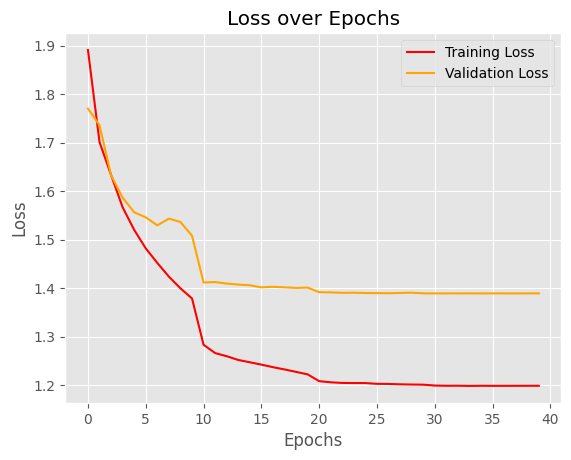

In [8]:
plt.plot(cesTrainLoss, label='Training Loss', color='red')
plt.plot(cesValidLoss, label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [9]:
# Print the memory usage
print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak usage: {peak / 10**6:.2f} MB")

Current memory usage: 0.44 MB
Peak usage: 1.92 MB


In [10]:
import torch

# Memory usage gpu
print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Memory Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

torch.cuda.empty_cache()

Memory Allocated: 28.97 MB
Memory Cached: 44.00 MB


# Model Evaluation

Accuracy: 0.5212
Precision: 0.5167
Recall: 0.5212
F1-Score: 0.5180


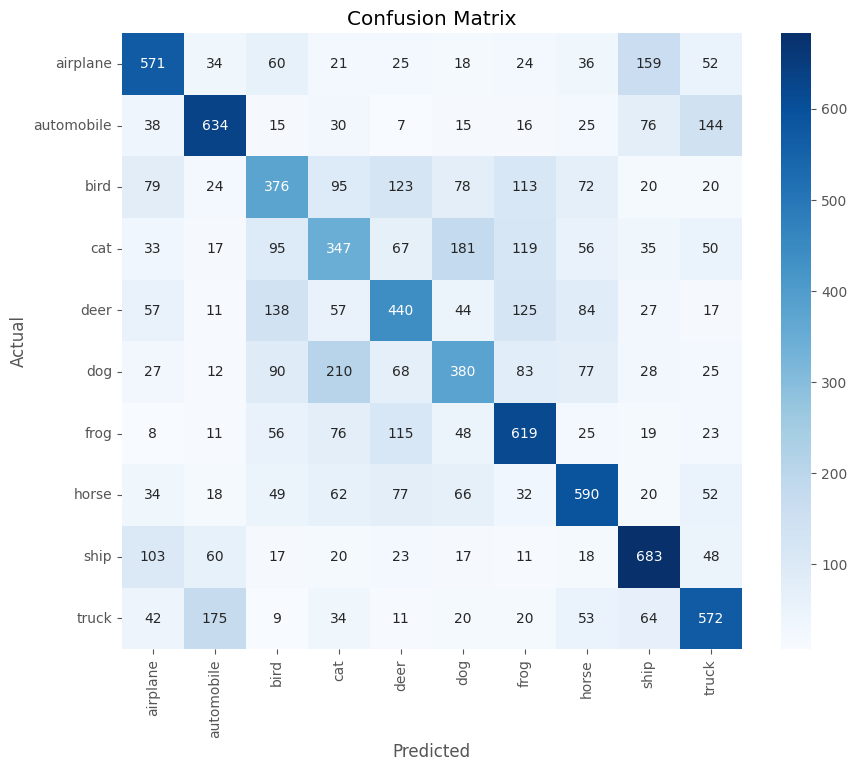

In [11]:
# Define the number of classes in the CIFAR-10 dataset
num_classes = 10

# Define metrics to evaluate the model's performance
accuracy = MulticlassAccuracy(num_classes=num_classes, average="macro")
precision = MulticlassPrecision(num_classes=num_classes, average="macro")
recall = MulticlassRecall(num_classes=num_classes, average="macro")
f1 = MulticlassF1Score(num_classes=num_classes, average="macro")
conf_matrix = MulticlassConfusionMatrix(num_classes=num_classes) # Confusion matrix to visualize model predictions

# load data from test loader
model.eval()
all_preds = [] # List to store predictions
all_labels = [] # List to store actual labels

# No gradient calculation needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # max predict value
        # Convert predictions and labels to numpy for metric calculation
        all_preds.extend(predicted.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy()) 
        
# Convert predictions and labels to tensors for metric calculation
all_preds = torch.tensor(all_preds)
all_labels = torch.tensor(all_labels)

# Evaluate model performance using defined metrics
acc = accuracy(all_preds, all_labels)
prec = precision(all_preds, all_labels)
rec = recall(all_preds, all_labels)
f1_score = f1(all_preds, all_labels)
conf_matrix_result = conf_matrix(all_preds, all_labels)

# Print evaluation metrics
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_result.numpy(), annot=True, fmt="d", cmap="Blues", xticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
], yticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Further Usage

In [12]:
torch.save(model, "pytorch_model.pth")  # model

In [13]:
# load model
loaded_model = torch.load("pytorch_model.pth", weights_only=False)
loaded_model.eval()


MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

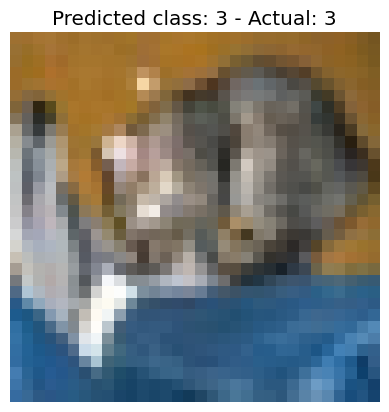

In [14]:
single_image = X_test[0]  # fist image in test
single_image = torch.tensor(single_image).unsqueeze(0).to(device) # Convert the image to a tensor, add a batch dimension, and move it to the device (GPU or CPU)
output = loaded_model(single_image) # Get the model's output for the selected image
predicted_class = torch.argmax(output, 1).item() # Get the predicted class by finding the index of the maximum output

# Convert the tensor back to CPU, remove the batch dimension, and reshape for displaying as an image
single_image_cpu = single_image.squeeze().cpu().numpy().reshape(32, 32, 3) 

# show image
y_test = np.argmax(y_test, axis=1) # Convert the true labels (one-hot encoded) to class indices
plt.imshow(single_image_cpu, cmap='gray') 
plt.title(f"Predicted class: {predicted_class} - Actual: {y_test[0]}")
plt.axis('off')
plt.show()


GPU usage

In [15]:
import GPUtil as GPU

# chekc GPU usage
GPUs = GPU.getGPUs()
for gpu in GPUs:
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU RAM Free: 2089MB | Used: 1876MB | Util  46% | Total 4096MB
